In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from tempfile import gettempdir


In [2]:
file = open('QuanSongCi.txt',encoding="utf8")
dataTotal = file.read()
chars = list(set(dataTotal))
data_size, num_classes = len(dataTotal), len(chars)
words = chars

In [3]:
vocabulary_size = 5000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 1011], ('搊', 1), ('坚', 1), ('彷', 1), ('谪', 1)]
Sample data [1, 2, 3, 17, 4, 7, 9, 12, 14, 19]


In [4]:

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['搊', '坚', '彷', '駈', '谪', '骍', '屼', '咻']

with num_skips = 2 and skip_window = 1:
    batch: ['坚', '坚', '彷', '彷', '駈', '駈', '谪', '谪']
    labels: ['彷', '搊', '坚', '駈', '彷', '谪', '骍', '駈']

with num_skips = 4 and skip_window = 2:
    batch: ['彷', '彷', '彷', '彷', '駈', '駈', '駈', '駈']
    labels: ['谪', '駈', '坚', '搊', '彷', '谪', '坚', '骍']


In [5]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.nce_loss(softmax_weights, softmax_biases, train_labels,embed, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [6]:
num_steps = 400001
from six.moves import xrange
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 178.607941
Nearest to 堤: 璋, 蠙, 谣, 移, 噪, 窦, 骆, 儡,
Nearest to 谨: 法, 淦, , 鴂, 发, 籧, 勃, 粱,
Nearest to 谛: 翎, 儿, , 萦, 瘥, 邙, 助, 聃,
Nearest to 渌: 鄘, 浩, 攥, 坂, 抡, 伟, 夏, 脂,
Nearest to 筒: 疲, 纵, 到, 颙, 改, 赪, 篰, 怳,
Nearest to 骍: 者, 滪, 习, 篰, 共, 货, 乇, 氲,
Nearest to 颣: 厩, 跣, 圈, 尖, 摩, 涕, 眼, 鹆,
Nearest to 蜘: 搴, 咎, 簟, 祲, 彳, 曲, 幕, 敬,
Nearest to 呕: 般, 甓, 秾, 店, , 莫, 僻, 笙,
Nearest to 泖: 灸, 邵, 堍, 诸, 杨, 虔, 滞, 蓬,
Nearest to 邱: 陷, 境, 钳, 召, 嗷, 皴, 咸, 匣,
Nearest to 贰: 躞, 裉, 鵕, 浔, 粜, 趟, 仟, 艮,
Nearest to 羊: 雏, 帽, 饱, 蜍, 虱, 俳, 眚, 沍,
Nearest to 牥: 侈, 掖, 肠, 扬, 旻, 鞮, 浚, 纟,
Nearest to 嶓: 但, 鬖, 皋, 舷, 箬, 谳, 么, 酌,
Nearest to 愧: , 尾, 钝, 盥, 忏, 軿, 傀, 蹒,
Average loss at step 2000: 19.504706
Average loss at step 4000: 0.858551
Average loss at step 6000: 0.667425
Average loss at step 8000: 0.642524
Average loss at step 10000: 0.617772
Nearest to 堤: 璋, 窦, 骆, 揭, 谣, 蠙, 瘥, 蛾,
Nearest to 谨: 籧, 外, 法, 捧, 嘘, 代, 披, 中,
Nearest to 谛:

Average loss at step 98000: 0.553185
Average loss at step 100000: 0.547153
Nearest to 堤: 窦, 璋, 揭, 谣, 瘥, 儡, 駣, 骆,
Nearest to 谨: 外, 籧, 法, 捧, 嘘, 代, 噪, 中,
Nearest to 谛: 翎, 萦, 屠, , 儿, 拄, 馌, 胡,
Nearest to 渌: 鄘, 攥, 疾, 哩, 濠, 妹, 祝, 抡,
Nearest to 筒: 疲, 焰, 纵, 萤, 到, 磅, 蔷, 篰,
Nearest to 骍: 者, 乇, 习, 篰, 滪, 棣, 共, 帨,
Nearest to 颣: 厩, 尖, 圈, 摩, 莠, 辽, 娣, 跣,
Nearest to 蜘: 簟, 彳, 蕾, 祲, 幕, 戊, 刃, 咎,
Nearest to 呕: 甓, 般, 莫, 狮, 囿, 秾, 僻, 店,
Nearest to 泖: 邵, 灸, 诸, 蓬, 奴, 鹜, 眇, 堍,
Nearest to 邱: 陷, 嗷, 匣, 钳, 芰, , 咸, 烧,
Nearest to 贰: 躞, 趟, 裉, 亩, 挥, 不, 仟, 鵕,
Nearest to 羊: 帽, 饱, 雏, 眚, 恻, 墓, 擢, 沍,
Nearest to 牥: 侈, 瓃, 纟, 旻, 掖, 饭, 偿, 浚,
Nearest to 嶓: 鬖, 但, 箬, 皋, 衾, 谳, ④, 舷,
Nearest to 愧: 軿, , 敌, 蹒, 傀, 黏, 溅, 矧,
Average loss at step 102000: 0.557699
Average loss at step 104000: 0.547414
Average loss at step 106000: 0.553490
Average loss at step 108000: 0.562340
Average loss at step 110000: 0.555089
Nearest to 堤: 窦, 璋, 谣, 揭, 瘥, 儡, 骆, 蛾,
Nearest to 谨: 籧, 外, 法, 捧, 嘘, 代, 噪, 潸,
Nearest to 谛: 翎, 萦, 屠, 儿, , 拄, 厌, 鹥,
Nearest to 渌:

Average loss at step 202000: 0.543367
Average loss at step 204000: 0.548471
Average loss at step 206000: 0.553128
Average loss at step 208000: 0.546020
Average loss at step 210000: 0.552263
Nearest to 堤: 窦, 璋, 瘥, 谣, 儡, 揭, 骆, 駣,
Nearest to 谨: 外, 籧, 法, 代, 捧, 嘘, 噪, 榛,
Nearest to 谛: 翎, 萦, 屠, 儿, , 拄, 悒, 瘥,
Nearest to 渌: 鄘, 攥, 濠, 疾, 祝, 哩, 妹, 脂,
Nearest to 筒: 疲, 纵, 萤, 磅, 焰, 到, 篰, 蔷,
Nearest to 骍: 者, 习, 棣, 乇, 篰, 滪, 帨, 共,
Nearest to 颣: 厩, 摩, 尖, 圈, 莠, 滋, 醲, 口,
Nearest to 蜘: 簟, 蕾, 幕, 彳, 祲, 戊, 迸, 蹴,
Nearest to 呕: 甓, 般, 莫, 囿, 狮, 僻, 淄, 攘,
Nearest to 泖: 邵, 灸, 诸, 眇, 蓬, 堍, 奴, 眄,
Nearest to 邱: 陷, 嗷, 匣, 芰, 钳, , 飘, 立,
Nearest to 贰: 躞, 趟, 挥, 裉, 不, 诫, 亩, 仟,
Nearest to 羊: 帽, 饱, 眚, 雏, 恻, 墓, 擢, 虱,
Nearest to 牥: 侈, 纟, 瓃, 掖, 鹚, 旻, 饭, 偿,
Nearest to 嶓: 鬖, 但, 箬, 皋, 衾, 谳, ④, 郿,
Nearest to 愧: 軿, , 敌, 蹒, 黏, 矧, 傀, 凊,
Average loss at step 212000: 0.541434
Average loss at step 214000: 0.543270
Average loss at step 216000: 0.554092
Average loss at step 218000: 0.548248
Average loss at step 220000: 0.553963
Nearest to 堤

Average loss at step 312000: 0.548161
Average loss at step 314000: 0.545613
Average loss at step 316000: 0.536072
Average loss at step 318000: 0.544752
Average loss at step 320000: 0.538138
Nearest to 堤: 窦, 璋, 谣, 瘥, 揭, 儡, 艺, ⒄,
Nearest to 谨: 外, 籧, 代, 法, 捧, 噪, 嘘, 悠,
Nearest to 谛: 翎, 萦, 屠, 拄, 儿, , 悒, 缩,
Nearest to 渌: 鄘, 攥, 疾, 濠, 妹, 哩, 沦, 祝,
Nearest to 筒: 疲, 萤, 纵, 到, 磅, 篰, 焰, 樻,
Nearest to 骍: 者, 习, 棣, 篰, 乇, 滪, 共, 骊,
Nearest to 颣: 厩, 摩, 尖, 圈, 莠, 醲, 颅, 扰,
Nearest to 蜘: 簟, 蕾, 蹴, 幕, 祲, 戊, 彳, 迸,
Nearest to 呕: 莫, 般, 甓, 囿, 僻, 狮, 秾, 淄,
Nearest to 泖: 邵, 灸, 诸, 蓬, 眇, 奴, 堍, 眄,
Nearest to 邱: 陷, 嗷, 匣, 芰, , 立, 飘, 序,
Nearest to 贰: 趟, 躞, 挥, 诫, 不, 亩, 仟, 裉,
Nearest to 羊: 帽, 眚, 饱, 雏, 恻, 墓, 擢, 虱,
Nearest to 牥: 侈, 纟, 鹚, 瓃, 偿, 旻, 饭, 浚,
Nearest to 嶓: 鬖, 箬, 衾, 但, 皋, 谳, ④, 逶,
Nearest to 愧: 軿, , 蹒, 敌, 凊, 黏, 矧, 傀,
Average loss at step 322000: 0.539118
Average loss at step 324000: 0.547696
Average loss at step 326000: 0.544849
Average loss at step 328000: 0.547184
Average loss at step 330000: 0.538929
Nearest to 堤

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

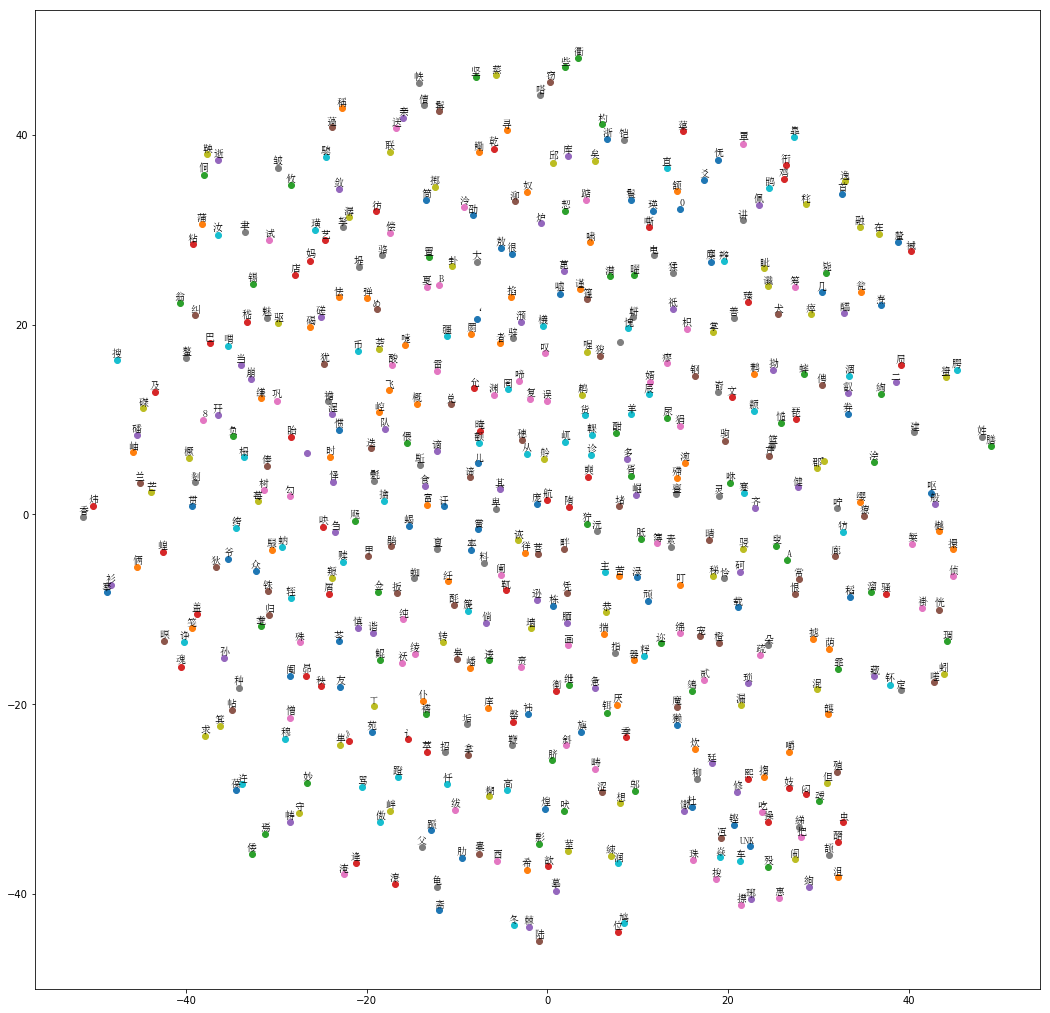

In [7]:
from matplotlib.font_manager import FontProperties
ChineseFont1 = FontProperties(fname = 'C:\\Windows\\Fonts\\simsun.ttc')

def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',fontproperties = ChineseFont1,
                 va='bottom')

  plt.savefig(filename)
from matplotlib import font_manager

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))
except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

In [13]:
print(gettempdir())

C:\Users\zhi\AppData\Local\Temp


In [14]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

In [15]:
np.save(outfile, final_embeddings)

In [16]:
outfile.seek(0)dictionary, reverse_dictionary

0

In [17]:
np.load(outfile)

array([[ 0.00121622,  0.00623623,  0.00786332, ..., -0.01806835,
        -0.35388386,  0.0302667 ],
       [-0.01271469,  0.02245513,  0.10717005, ..., -0.10162421,
        -0.11170832,  0.10021088],
       [-0.07742595, -0.06922957,  0.05039036, ...,  0.07292641,
        -0.00301739,  0.04024274],
       ..., 
       [-0.06806442,  0.07582098, -0.03712125, ...,  0.08247469,
        -0.01650273, -0.08150265],
       [-0.07800205,  0.08960694,  0.069544  , ...,  0.05628275,
         0.02397816,  0.03784458],
       [-0.05808216,  0.01478665, -0.04028169, ..., -0.03359636,
        -0.04402011,  0.09237343]], dtype=float32)

In [19]:
import json
with open('dict.json','w') as fp:
    json.dump(dictionary,fp)

In [20]:
with open('revdict.json','w') as fp:
    json.dump(reverse_dictionary,fp)